## Dataset

Veamos estadísticas y otras cosas del dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

Primero, veamos qué usuarios etiquetaron más de 4 artículos...

In [2]:
from django.db.models import Count, Case, When, Value

annotated_articles = Article.objects.exclude(batch__name="training").annotate(
    num_labels=Count('labels'),
    effective_labels=Count(
        Case(When(labels__is_interesting=True, then=Value(1)))
    )
)


dataset_articles = annotated_articles.filter(effective_labels=3)

skipped = 0

for art in annotated_articles:
    if art.num_labels > art.effective_labels:
        skipped +=1


print(f"Artículos totales: {Article.objects.count()}")
print(f"Artículos con 3 anotaciones: {dataset_articles.count()}")
print(f"Artículos con alguna anotación: {annotated_articles.filter(num_labels__gte=1).count()}")
print(f"Artículos que no pasaron a tercera anotación: {skipped}")

Artículos totales: 1738
Artículos con 3 anotaciones: 1238
Artículos con alguna anotación: 1725
Artículos que no pasaron a tercera anotación: 452


Vamos a crear primero tabla de comentarios

Text(0.5, 1.0, 'Distribution of article dates')

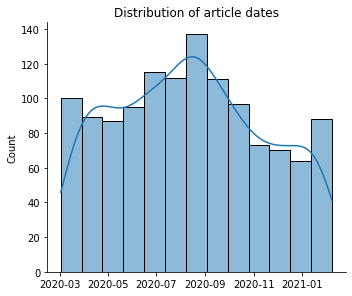

In [3]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

dates = [d.created_at for d in dataset_articles]

ax = sns.displot(
    x=dates, 
    kde=True, 
    height=4, aspect=1.25,
)

plt.title("Distribution of article dates")

In [4]:
import pandas as pd

comments = pd.DataFrame([{
    "comment_id": comment.tweet_id,
    "article_id": art.tweet_id,
    "text": comment.text,
    "user_id": comment.user_id,
} for art in dataset_articles for comment in art.comment_set.all()])

comments.set_index("comment_id", inplace=True)

comments

,article_id,text,user_id
comment_id,,,
1241513939499876354,1241486782178435072,@usuario Momento oportuno para hacer esa movid...,1173653523478851593
1241524087773593600,1241486782178435072,@usuario vienen medicos cubanos... ahhh pero n...,2492207160
1241493802222850049,1241486782178435072,@usuario Otros virus más?,900774786736979969
1241776452300869632,1241486782178435072,@usuario Quien diría q un día Cristina estaría...,1218288879800811521
1241801967669776384,1241486782178435072,"@usuario Ya que no devuelven TODO,es lo menos ...",3144238919
...,...,...,...
1357362025203200002,1357326733058461696,@usuario Nunca olvidar que este gobierno hizo ...,147954815
1357358187712757762,1357326733058461696,@usuario Esos pseudohumanos nos están matando ...,150045518
1357528904228081664,1357326733058461696,"@usuario Que tristeza dios mio, que en paz des...",615411644


[]

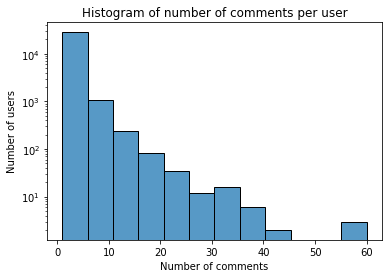

In [5]:
user_counts = comments["user_id"].value_counts().to_frame("number of comments")
sns.histplot(data=user_counts, x="number of comments", hue=None, bins=12)

plt.ylabel("Number of users")
plt.xlabel("Number of comments")
plt.title("Histogram of number of comments per user")
plt.semilogy()

Vamos a serializar esto:

In [6]:
from dataset import CommentSerializer, ArticleSerializer, field_mapping


serializer = CommentSerializer()
article_serializer = ArticleSerializer()

articles = []
comments = []


finished_articles = annotated_articles.filter(effective_labels=3).prefetch_related('comment_set', 'labels')
ignored_labels = 0

for article in tqdm(finished_articles):
    articles.append(article_serializer.serialize(article))
    for comment in article.comment_set.all():    
        new_comment = serializer.serialize(comment)
        comments.append(new_comment)

  0%|          | 0/1238 [00:00<?, ?it/s]

Veamos la forma de alguno

In [7]:
next(c for c in comments if c["HATE"])

{'id': 327917,
 'text': '@usuario vienen medicos cubanos... ahhh pero no veo ninguna ayuda norteamericana, quienes ni siquiera les importa, seguro que ellos generaron esto, lacras de mierda',
 'article_id': 1241486782178435072,
 'annotators': ['annotator_5', 'annotator_2', 'annotator_1'],
 'HATE': ['annotator_2'],
 'CALLS': [],
 'WOMEN': [],
 'LGBTI': [],
 'RACISM': ['annotator_2'],
 'CLASS': [],
 'POLITICS': [],
 'DISABLED': [],
 'APPEARANCE': [],
 'CRIMINAL': []}

Text(0.5, 1.0, 'Histogram of hateful annotations per comment')

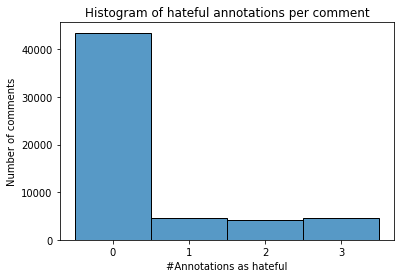

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(x=[len(c['HATE']) for c in comments], bins=[0, 1, 2, 3, 4])

plt.xticks([0.5, 1.5, 2.5, 3.5], [0, 1, 2, 3])
plt.xlabel("#Annotations as hateful")
plt.ylabel("Number of comments")
plt.title("Histogram of hateful annotations per comment")

In [9]:
possibly_hateful = len([c for c in comments if len(c['HATE']) > 0])
hateful = len([c for c in comments if len(c['HATE']) >= 2])

full_agreement = len([c for c in comments if len(c['HATE']) == 3])

print(f"Comentarios totales                             : {len(comments)}")
print(f"Comentarios con >= 1 etiqueta de discriminación : {possibly_hateful}")
print(f"Comentarios con >= 2 etiqueta de discriminación : {hateful}")
print(f"Comentarios con >= 3 etiqueta de discriminación : {full_agreement}")
print(f"Ratio de comentarios odiosos (>= 2) sobre totales = {hateful / len(comments):.3f}")

Comentarios totales                             : 56869
Comentarios con >= 1 etiqueta de discriminación : 13366
Comentarios con >= 2 etiqueta de discriminación : 8715
Comentarios con >= 3 etiqueta de discriminación : 4514
Ratio de comentarios odiosos (>= 2) sobre totales = 0.153


## Agreement

In [21]:
from api.metrics import AgreementCalculator

calculator = AgreementCalculator(articles=dataset_articles)

  0%|          | 0/4769 [00:09<?, ?it/s]

In [22]:
calculator.users = None

In [31]:
categories = [
    'HATE',
    'CALLS',
    'MUJER',
    'LGBTI',
    'RACISMO',
    'POBREZA',
    'DISCAPACIDAD',
    'POLITICA',
    'ASPECTO',
    'CRIMINAL',
]

agreement_df = pd.DataFrame([{
    "Category": category,
    "Agreement": calculator.get_agreement(on=category)[0],
} for category in categories])
agreement_df.set_index("Category")

,Agreement
Category,
HATE,0.579610
CALLS,0.478974
MUJER,0.530894
LGBTI,0.554911
RACISMO,0.607848
POBREZA,0.403643
DISCAPACIDAD,0.596529
POLITICA,0.508691
ASPECTO,0.734578


Cambia algo si vemos el agreement por categorías pero sólo en los odiosos? 

Es decir, calculo el alpha pero sólo en el universo de comentarios odiosos

In [41]:
hateful_comment_ids = [c['id'] for c in comments if len(c['HATE']) >= 2]

calculator = AgreementCalculator(comment_ids=hateful_comment_ids)

In [46]:
categories = [
    'CALLS',
    'MUJER',
    'LGBTI',
    'RACISMO',
    'POBREZA',
    'DISCAPACIDAD',
    'POLITICA',
    'ASPECTO',
    'CRIMINAL',
]

agreement_df = pd.DataFrame([{
    "Category": category,
    "Agreement": calculator.get_agreement(on=category)[0],
} for category in categories])
agreement_df.set_index("Category").sort_values("Agreement", ascending=False)

,Agreement
Category,
ASPECTO,0.761484
CRIMINAL,0.718144
LGBTI,0.711184
RACISMO,0.702249
DISCAPACIDAD,0.690662
MUJER,0.615003
POLITICA,0.595000
POBREZA,0.525726
CALLS,0.502730


Da mejor! Puede que tenga sentido sólo calcularlos acá

## Asignación